In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
# from tf.keras.models import Sequential # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

In [3]:
from matplotlib import font_manager, rc
import matplotlib

#한글 폰트 등록
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [4]:
# import pandas as pd

# # 판다스 데이터프레임(DataFrame)을 출력할 때, 최대 출력할 수 있는 컬럼을 100개로 늘려줍니다.
# # 이렇게 해야 데이터를 분석할 때 출력해서 확인하기 편합니다.
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

In [5]:
# train = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/train.csv')
# test = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/test.csv')

In [6]:
weather_time = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/인천_시간별_기상자료.csv',encoding='euc-kr',index_col='일시',parse_dates=True)
del weather_time['지점']

In [7]:
# for k in range(1,len(train.columns) ): #시간을 제외한 1열부터 마지막 열까지를 for문으로 작동시킵니다.
#     train_median=train.iloc[:,k].median() #값을 대체하는 과정에서 값이 변경 될 것을 대비해 해당 세대의 중앙값을 미리 계산하고 시작합니다.
#     counting=train.loc[ train.iloc[:,k].isnull()==False ][ train.columns[k] ].index

#     df=pd.DataFrame( list( zip( counting[:-1], counting[1:] - counting[:-1] -1  ) ), columns=['index','count'] )
    
#     df2= df[ (df['count'] > 0) ] #결측치가 존재하는 부분만 추출
#     df2=df2.reset_index(drop=True) #기존에 존재하는 index를 초기화 하여 이후 for문에 사용함

#     for i,j in zip( df2['index'], df2['count'] ) : # i = 해당 세대에서 값이 존재하는 index, j = 현재 index 밑의 결측치 갯수
#         if train.iloc[i,k]>=train_median: #현재 index에 존재하는 값이 해당 세대의 중앙 값 이상일때만 분산처리 실행
#             train.iloc[ i : i+j+1 , k] = train.iloc[i,k] / (j+1) 
#             #현재 index 및 결측치의 갯수 만큼 지정을 하여, 현재 index에 있는 값을 해당 갯수만큼 나누어 줍니다
#         else:
#             pass
#             #현재 index에 존재하는 값이 중앙 값 미만이면 pass를 실행
#     if k%50==0: #for문 진행정도 확인용
#             print(k,"번째 실행중")

In [8]:
# for k in range(1,len(test.columns) ): #시간을 제외한 1열부터 마지막 열까지를 for문으로 작동시킵니다.
#     test_median=test.iloc[:,k].median() #값을 대체하는 과정에서 값이 변경 될 것을 대비해 해당 세대의 중앙값을 미리 계산하고 시작합니다.
#     counting=test.loc[ test.iloc[:,k].isnull()==False ][ test.columns[k] ].index

#     df=pd.DataFrame( list( zip( counting[:-1], counting[1:] - counting[:-1] -1  ) ), columns=['index','count'] )
    
#     df2= df[ (df['count'] > 0) ] #결측치가 존재하는 부분만 추출
#     df2=df2.reset_index(drop=True) #기존에 존재하는 index를 초기화 하여 이후 for문에 사용함

#     for i,j in zip( df2['index'], df2['count'] ) : # i = 해당 세대에서 값이 존재하는 index, j = 현재 index 밑의 결측치 갯수
#         if test.iloc[i,k]>=test_median: #현재 indetestx에 존재하는 값이 해당 세대의 중앙 값 이상일때만 분산처리 실행
#             test.iloc[ i : i+j+1 , k] = test.iloc[i,k] / (j+1) 
#             #현재 index 및 결측치의 갯수 만큼 지정을 하여, 현재 index에 있는 값을 해당 갯수만큼 나누어 줍니다
#         else:
#             pass
#             #현재 index에 존재하는 값이 중앙 값 미만이면 pass를 실행
#     if k%50==0: #for문 진행정도 확인용
#             print(k,"번째 실행중")

In [9]:
# train['Time'] = train['Time'].apply(pd.to_datetime)
# train.set_index('Time',inplace=True)

# test['Time'] = test['Time'].apply(pd.to_datetime)
# test.set_index('Time',inplace=True)

In [10]:
# train_sample = train['2018-02-15':]
# train_sample = train_sample.interpolate(method='values')

# test_sample = test['2018-02-15':]
# test_sample = test_sample.interpolate(method='values')

In [11]:
# 결측값 가진 행 제거 - 데이터가 아예 없는 경우
# train_sample.loc[:,train_sample.isnull().sum() >= 1].columns

In [12]:
# #결측값 가진 행 제거 - 데이터가 아예 없는 경우
# test_sample.loc[:,test_sample.isnull().sum() >= 1].columns

In [13]:
# # forecast_test.csv 생성시에는 여기 실행 X

# train_sample.drop(['X4', 'X127', 'X9', 'X65', 'X54', 'X13', 'X53', 'X24', 'X17', 'X14',
#        'X48', 'X2', 'X19', 'X36', 'X28', 'X63', 'X38', 'X39', 'X8', 'X64',
#        'X29', 'X57', 'X705', 'X71', 'X3', 'X27', 'X22', 'X21', 'X118', 'X6',
#        'X45', 'X40', 'X66', 'X52', 'X12', 'X49', 'X1', 'X33', 'X60', 'X46',
#        'X963', 'X56', 'X15', 'X11', 'X25', 'X34', 'X23', 'X58'], axis=1, inplace=True)

# test_sample.drop(['X26', 'X16', 'X7', 'X18', 'X41', 'X55', 'X5', 'X43', 'X59', 'X10',
#        'X62', 'X61', 'X32', 'X31', 'X30', 'X51', 'X35', 'X44', 'X37', 'X42',
#        'X50', 'X47', 'X20'],axis=1,inplace=True)

In [14]:
############################################# 결측치 처리 ###############################################################

In [15]:
# # 1차 중간저장 ( 결측치 처리)

# train_sample.to_csv('train_sample')
# test_sample.to_csv('test_sample')

In [16]:
## 결측치 처리 된 Data Load
train_sample = pd.read_csv('train_sample',index_col='Time',parse_dates=True)
test_sample = pd.read_csv('test_sample',index_col='Time',parse_dates=True)

In [17]:
############################################# 입력신호 추가 ###############################################################

In [18]:
# 일별 형태로 변환
train_sample = train_sample.resample('D').sum()
test_sample = test_sample.resample('D').sum()

In [19]:
train_sample['temp'] = weather_time['기온(°C)']['2018-02-15':].resample('D').mean() 
train_sample['humidity'] = weather_time['습도(%)']['2018-02-15':].resample('D').mean() 
train_sample[['temp','humidity']] = train_sample[['temp','humidity']].interpolate(method='values')  # 온도 결측값을 시간에 따른 보간법으로 채움
train_sample['DayOfWeek'] = train_sample.index.dayofweek


test_sample['temp'] = weather_time['기온(°C)']['2018-02-15':].resample('D').mean()
test_sample['humidity'] = weather_time['습도(%)']['2018-02-15':].resample('D').mean() 
test_sample[['temp','humidity']] = test_sample[['temp','humidity']].interpolate(method='values')  # 온도 결측값을 시간에 따른 보간법으로 채움
test_sample['DayOfWeek'] = train_sample.index.dayofweek

In [20]:
# forecast_test csv 생성
# test_sample.to_csv('forecast_test') 

In [21]:
## holiday_list 에 공휴일과 토요일/일요일 날짜를 넣음

# 공휴일 목록
holiday_list=['2018-02-15','2018-02-16','2018-02-17','2018-03-01','2018-05-05','2018-05-07','2018-05-22','2018-06-06','2018-06-13']

# 토요일/일요일 

a= train_sample['2018-02-17':].index
b= train_sample['2018-02-19':].resample('B').sum().index

list_a = []
for i in range(len(a.values)):
    list_a.append(a.values[i])
list_b = []
for i in range(len(b.values)):
    list_b.append(b.values[i])

list_tmp = []
for i in list_a:
    if i not in list_b:
        list_tmp.append(i)
      
    
# list_tmp # 토요일/일요일
saturday_sunday = np.array(list_tmp) # 툐요일/일요일 index => ndarray

# # 주말목록 / 주말색인 구한 뒤 합침
for i in range(len(saturday_sunday)):
    holiday_list.append(str(saturday_sunday[i])[:10])

In [22]:
## 데이터 minmax scaling

from sklearn.preprocessing import MinMaxScaler

# train/test/temp/humidity/DayOfWeek 각 feature 별로 scaler 구현
sc_train = MinMaxScaler() # trainSet scaler
sc_test = MinMaxScaler() # testSet scaler
sc_temp = MinMaxScaler() # temp scaler
sc_humidity = MinMaxScaler() # humidity scaler
sc_DayOfWeek = MinMaxScaler() # DayOfWeek scaler

# scaling
train_sample_sc = sc_train.fit_transform(train_sample.iloc[:,:-3])
test_sample_sc = sc_test.fit_transform(test_sample.iloc[:,:-3])
temp_sc = sc_temp.fit_transform(train_sample[['temp']])
humidity_sc = sc_humidity.fit_transform(train_sample[['humidity']])
DayOfWeek_sc = sc_DayOfWeek.fit_transform(train_sample[['DayOfWeek']])

# feature scale 데이터를 다시 합침 ( train + feature)
# np.cocatenate
train_sample_sc = np.concatenate((train_sample_sc, temp_sc), axis=1)
train_sample_sc = np.concatenate((train_sample_sc, humidity_sc), axis=1)
train_sample_sc = np.concatenate((train_sample_sc, DayOfWeek_sc), axis=1)


# feature scale 데이터를 다시 합침 ( test + feature)
# np.concatenate
test_sample_sc = np.concatenate((test_sample_sc, temp_sc), axis=1)
test_sample_sc = np.concatenate((test_sample_sc, humidity_sc), axis=1)
test_sample_sc = np.concatenate((test_sample_sc, DayOfWeek_sc), axis=1)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [23]:
# 다시 DataFrame 으로
train_sample = pd.DataFrame(train_sample_sc, columns=train_sample.columns,index=train_sample.index)
test_sample = pd.DataFrame(test_sample_sc, columns=test_sample.columns,index=test_sample.index)

In [24]:
# train,test DataFrame에 주말/공휴일 feature를 추가

train_sample['holiDay'] = 0 # holiday feature 추가 / 우선 0으로 

for i in range(len(train_sample)):
    if str(train_sample.index[i])[:10] in holiday_list :
        train_sample['holiDay'].iloc[i] = 1 # 쉬는날이면 1
    else:
        train_sample['holiDay'].iloc[i] = 0 # 쉬는날 아니면 0
        
# 같은방법으로 test_sample도

test_sample['holiDay'] = 0 # holiday feature 추가 / 우선 0으로 

for i in range(len(test_sample)):
    if str(test_sample.index[i])[:10] in holiday_list :
        test_sample['holiDay'].iloc[i] = 1 # 쉬는날이면 1
    else:
        test_sample['holiDay'].iloc[i] = 0 # 쉬는날 아니면 0

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [25]:
## 중간 저장 (2차) ##
## 결측치,feature추가,scaling 완료

In [26]:
# train_sample.to_csv('train_sample_forecast_일별')
# test_sample.to_csv('test_sample_forecast_일별')

In [72]:
train_sample = pd.read_csv('train_sample_forecast_일별',index_col='Time',parse_dates=True) # scaling 된거
test_sample = pd.read_csv('test_sample_forecast_일별',index_col='Time',parse_dates=True)

In [28]:
#################################################### Shifting #################################################################

In [29]:
shift_step = 7

In [30]:
############################################### Train DATA #############################################################

In [31]:
tmp_list = [] 
# 각 세대별 전력수요량+feature의 값을 model input 형식에 맞춤

for i in train_sample.columns[:-4]: # 임시 list에 [전력량,기온,DayOfWeek,holiDay,humidity]의 형식으로 값을 하나씩 저장
    tmp_list.append(train_sample[[i,'temp','DayOfWeek','holiDay','humidity']]["2018-02-17":'2018-06-29'].values[:-shift_step].reshape(18,7,5)) 

# reshape 위해 2018-02-21이후로 인덱싱 해줌    
    
to_formatted_x = np.array(tmp_list)

In [32]:
# res_x에 모든train 세대의 데이터(전력수요량,feature) 전부 넣음
res_x = to_formatted_x.reshape(to_formatted_x.shape[0]*to_formatted_x.shape[1],7,5)

res_x.shape

(22536, 7, 5)

> input=(전력수요량,기온,DayOfWeek,holiDay,humidity)  =>  output=(전력수요량)

In [33]:
for_shifting_y = train_sample.shift(-shift_step)

tmp_shift_list = []
for i in train_sample.columns[:-4]:
    tmp_shift_list.append(for_shifting_y[i]['2018-02-17':"2018-06-29"].values[:-shift_step].reshape(18,7,1))

to_formatted_y = np.array(tmp_shift_list)

In [34]:
res_y = to_formatted_y.reshape(to_formatted_x.shape[0]*to_formatted_x.shape[1],7,1)

res_y.shape

(22536, 7, 1)

In [35]:
############################################### TEST DATA #############################################################

In [36]:
tmp_test_list = [] 
for i in test_sample.columns[:-4]:
    tmp_test_list.append(test_sample[[i,'temp','DayOfWeek','holiDay','humidity']]['2018-02-17':"2018-06-29"].values[:-shift_step].reshape(18,7,5)) 

to_formatted_test_x = np.array(tmp_test_list)

In [37]:
res_test_x = to_formatted_test_x.reshape(to_formatted_test_x.shape[0]*to_formatted_test_x.shape[1],7,5)

res_test_x.shape

(3186, 7, 5)

In [38]:
for_shifting_y = test_sample.shift(-shift_step)

tmp_test_shift_list = []
for i in test_sample.columns[:-4]:
    tmp_test_shift_list.append(for_shifting_y[i]['2018-02-17':"2018-06-29"].values[:-shift_step].reshape(18,7,1))

to_formatted_test_y = np.array(tmp_test_shift_list)

In [39]:
# to_formatted_test_y.shape

In [40]:
res_test_y = to_formatted_test_y.reshape(to_formatted_test_x.shape[0]*to_formatted_test_x.shape[1],7,1)

res_test_y.shape

(3186, 7, 1)

In [41]:
############################################### Model #############################################################

In [42]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 
from keras.layers import TimeDistributed
K.clear_session()

model = Sequential() # Sequeatial Model 
model.add(LSTM(128, input_shape=(7, 5),return_sequences=True)) # (timestep, feature)
model.add(TimeDistributed(Dense(1, activation="linear")))
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 128)            68608     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 1)              129       
Total params: 68,737
Trainable params: 68,737
Non-trainable params: 0
_________________________________________________________________


In [43]:
############################################### Model Training #############################################################

In [44]:
# 모델 학습
early_stop = EarlyStopping(monitor='loss',patience=4, verbose=1)

history = model.fit(res_x,res_y,epochs=50,batch_size=512,verbose=1,validation_split=0.2,shuffle=True,callbacks=[early_stop])


Train on 18028 samples, validate on 4508 samples
Epoch 1/50
18028/18028 [==============================] - 4s 205us/step - loss: 0.0880 - val_loss: 0.0459
Epoch 2/50
18028/18028 [==============================] - 4s 198us/step - loss: 0.0415 - val_loss: 0.0371
Epoch 3/50
18028/18028 [==============================] - 4s 197us/step - loss: 0.0362 - val_loss: 0.0338
Epoch 4/50
18028/18028 [==============================] - 4s 201us/step - loss: 0.0339 - val_loss: 0.0319
Epoch 5/50
18028/18028 [==============================] - 3s 187us/step - loss: 0.0321 - val_loss: 0.0302
Epoch 6/50
18028/18028 [==============================] - 4s 197us/step - loss: 0.0306 - val_loss: 0.0289
Epoch 7/50
18028/18028 [==============================] - 3s 193us/step - loss: 0.0295 - val_loss: 0.0281
Epoch 8/50
18028/18028 [==============================] - 4s 196us/step - loss: 0.0289 - val_loss: 0.0276
Epoch 9/50
18028/18028 [==============================] - 3s 193us/step - loss: 0.0285 - val_loss: 0.0

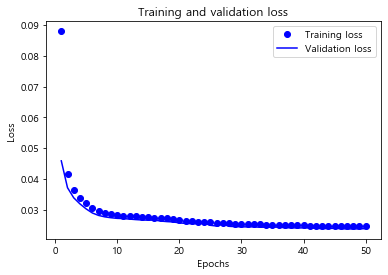

In [45]:
history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')# ‘bo’는 파란색 점
plt.plot(epochs, val_loss, 'b', label='Validation loss')# ‘b’는 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
############################################### Predict #############################################################

In [47]:
pred = model.predict(res_test_x)

In [48]:
## to inverse minmax scale

col_list = test_sample.columns.insert(0,'임시')
tt_index = test_sample['2018-02-24':'2018-06-29'].index

test_inverse_df = pd.DataFrame()

for i in range(1,len(test_sample.columns)-3):# feature 제외
    tmp = i*126
    tt = pred.reshape(22302,1)[tmp-126:tmp]    
    test_inverse_df[col_list[i]] = tt.reshape(126,)
    
test_inverse_df = test_inverse_df.set_index(tt_index)
test_inverse_df_array = sc_test.inverse_transform(test_inverse_df)

In [49]:
# inverse minmax scale DataFrame 
res_test_df = pd.DataFrame(test_inverse_df_array, columns=test_inverse_df.columns,index=tt_index)

In [50]:
# 예측한 결과물 DataFrame
# res_test_df

In [51]:
# 결과물과 원본 DataFrame 모두 inverse scaling 

In [52]:
test_none_scale = pd.read_csv('test_sample',index_col='Time',parse_dates=True)

In [53]:
test_none_scale = test_none_scale.loc[:,:'X230']['2018-02-24':'2018-06-29'].resample('D').sum()

In [54]:
test_sample.columns

Index(['X303', 'X241', 'X435', 'X402', 'X352', 'X305', 'X350', 'X326', 'X299',
       'X160',
       ...
       'X266', 'X443', 'X347', 'X75', 'X107', 'X230', 'temp', 'humidity',
       'DayOfWeek', 'holiDay'],
      dtype='object', length=181)

> 결과 체크

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


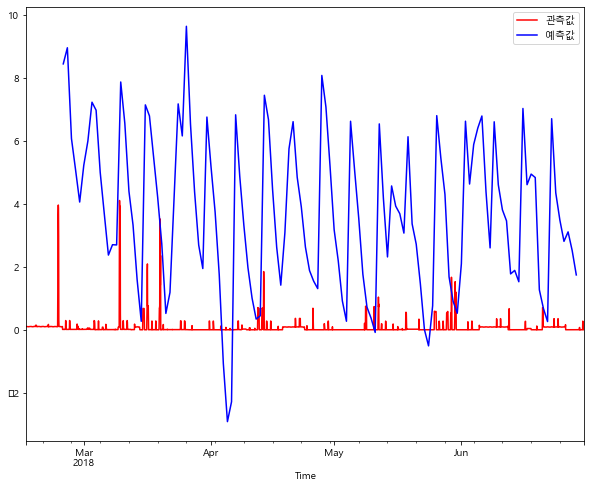

In [69]:
# 일별

test_none_scale['X94'].plot(figsize=(10,8),color='red',label='관측값')
res_test_df['X94'].plot(figsize=(10,8),color='blue',label='예측값')
plt.legend()

In [56]:
#################### forecast#########################

In [57]:
# 결측값 처리못한 컬럼까지 다시 포함하여 예측만을 위한 DataFrame 

forecast_test = pd.read_csv('forecast_test',index_col='Time',parse_dates=True)

In [58]:
from sklearn.preprocessing import MinMaxScaler

sc_test = MinMaxScaler() # testSet scaler

forecast_test_sc = sc_test.fit_transform(forecast_test.iloc[:,:-3])

forecast_test_sc = np.concatenate((forecast_test_sc, temp_sc), axis=1)
forecast_test_sc = np.concatenate((forecast_test_sc, humidity_sc), axis=1)
forecast_test_sc = np.concatenate((forecast_test_sc, DayOfWeek_sc), axis=1)

forecast_test = pd.DataFrame(forecast_test_sc, columns=forecast_test.columns,index=forecast_test.index)

forecast_test['holiDay'] = 0 # holiday feature 추가 / 우선 0으로 

for i in range(len(forecast_test)):
    if str(forecast_test.index[i])[:10] in holiday_list :
        forecast_test['holiDay'].iloc[i] = 1 # 쉬는날이면 1
    else:
        forecast_test['holiDay'].iloc[i] = 0 # 쉬는날 아니면 0

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [59]:
tmp_test_list = [] 
for i in forecast_test.columns[:-4]:
    tmp_test_list.append(forecast_test[[i,'temp','DayOfWeek','holiDay','humidity']]['2018-06-23':'2018-06-29'].values) 

to_formatted_test_x = np.array(tmp_test_list)

In [60]:
forecast_x = to_formatted_test_x

In [61]:
pred = model.predict(forecast_x)

In [62]:
# forecast_test

In [63]:
## to inverse minmax scale

col_list = forecast_test.columns.insert(0,'임시')
tt_index = forecast_test['2018-04-30':'2018-05-06'].index # 07/01 ~ 07/10

test_inverse_df = pd.DataFrame()

for i in range(1,len(forecast_test.columns)-3):# temp col 제외
    tmp = i*7
    tt = pred.reshape(1400,1)[tmp-7:tmp]    
    test_inverse_df[col_list[i]] = tt.reshape(7,)
    
test_inverse_df = test_inverse_df.set_index(tt_index)
test_inverse_df_array = sc_test.inverse_transform(test_inverse_df)

In [64]:
# inverse minmax scale DataFrame 

res_forecast = pd.DataFrame(test_inverse_df_array, columns=test_inverse_df.columns,index=tt_index)

In [65]:
test_none_scale = pd.read_csv('test_sample',index_col='Time',parse_dates=True)

In [66]:
# X94세대 특이

In [67]:
# res_forecast.to_csv("10일 일별 예측 결과") # 07/01 24시간

In [ ]:
## 2018-06-23 ~ 2018-06-29 의 데이터로 06-30~07-06 의 값을 예측하였다.
## 이를 토대로, 07-07~07-13의 데이터를 예측한 할것

In [75]:
new_tindex = pd.date_range("2018-06-30","2018-07-06")

In [78]:
res_forecast = res_forecast.set_index(new_tindex) # 인덱스 새로 설정 후 다시 예측모델에 넣기 위한 전처리 진행

In [ ]:
기온,습도,데이오브위크,

In [83]:
weather_day = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/인천_일별_기상자료.csv',encoding='euc-kr',index_col='일시',parse_dates=True)
del weather_day['지점']

In [82]:
weather_day

,지점,평균기온(°C),최저기온(°C),최고기온(°C)
일시,,,,
2016-07-20,112,28.1,24.6,31.6
2016-07-21,112,28.0,25.0,31.5
2016-07-22,112,28.5,25.9,32.3
2016-07-23,112,27.7,25.8,30.2
2016-07-24,112,27.0,26.4,28.9
...,...,...,...,...
2018-07-06,112,24.4,22.4,27.4
2018-07-07,112,23.9,19.4,28.7
2018-07-08,112,23.4,18.9,27.3


In [79]:
res_forecast

,X26,X303,X241,X435,X402,X352,X305,X350,X326,X299,X160,X125,X211,X349,X407,X330,X132,X231,X225,X16,X286,X354,X353,X76,X255,X106,X393,X157,X323,X130,X269,X94,X172,X289,X216,X123,X398,X233,X214,X270,X371,X200,X111,X163,X364,X378,X271,X462,X427,X73,X7,X263,X450,X18,X206,X133,X41,X195,X155,X134,X297,X175,X254,X196,X481,X412,X337,X406,X67,X414,X55,X91,X260,X252,X5,...,X178,X308,X217,X229,X358,X31,X148,X397,X363,X165,X30,X88,X296,X219,X116,X68,X431,X302,X314,X124,X405,X315,X51,X176,X396,X449,X383,X473,X205,X35,X161,X403,X341,X149,X82,X377,X232,X333,X140,X44,X37,X42,X422,X50,X386,X80,X250,X142,X235,X446,X331,X102,X186,X243,X194,X183,X139,X459,X457,X70,X368,X282,X426,X47,X192,X283,X329,X223,X266,X20,X443,X347,X75,X107,X230
2018-06-30,39.308633,13.279787,7.722209,5.447337,8.458534,4.829386,8.995309,7.017845,4.560868,5.875863,6.363612,26.427303,7.979033,7.706918,8.021234,9.237892,8.020472,5.233559,8.680640,96.269589,8.335018,5.391837,7.652313,37.705476,9.504103,16.399817,7.580491,6.159271,5.902851,10.151830,6.941883,7.316552,5.322667,7.831684,5.940417,17.089629,3.966126,6.755355,10.524181,10.802718,8.596904,4.682410,9.027661,6.948094,7.129977,8.281165,7.581379,6.972712,7.661067,6.019131,37.914640,7.389953,4.740180,49.407749,9.735245,8.578623,53.923661,8.170403,8.258743,10.926492,4.302991,11.662517,7.285462,12.922819,5.565669,0.824778,9.306354,5.900525,18.090652,5.160589,227.796184,26.926191,5.474893,10.918351,117.552680,...,9.938312,6.667831,7.614759,9.589240,6.041517,9.778608,6.747345,12.993797,7.460277,7.357458,120.624812,20.861827,6.561371,5.764721,23.165511,98.340069,8.867616,1.589562,5.408002,32.653002,5.800478,6.714271,302.224975,5.562667,4.911680,7.589166,5.938940,4.921554,10.203009,0.120239,12.455535,3.795155,6.751887,8.099608,26.562390,4.439384,10.781384,5.816625,11.755615,43.332791,85.400391,26.283060,7.613775,124.121620,7.600515,205.410659,14.672579,11.913807,4.080041,6.465078,8.152382,31.420277,6.981087,7.743150,5.064766,4.692514,7.809346,4.117662,7.097607,25.918893,8.079051,7.321453,6.799446,10.757205,6.981537,5.825353,6.973277,8.337318,8.421943,22.288620,7.920844,5.497690,46.884651,11.189690,9.914677
2018-07-01,37.863465,15.243667,7.238799,5.228989,8.581272,4.578121,8.555520,6.991363,4.582516,6.093306,5.948107,16.171784,7.084997,7.025638,7.586760,10.041802,7.322097,4.631038,8.445267,95.656725,7.454323,4.706407,6.571184,35.412056,8.524300,13.048263,7.015754,5.708198,5.564995,8.534934,6.624484,4.949482,4.099206,7.925470,6.235145,11.474002,4.129364,4.938762,10.384192,11.950797,7.790516,3.876399,6.675133,6.563305,7.306166,6.897422,7.401938,6.181134,7.311440,3.856870,37.616273,6.938884,3.491370,47.966803,8.583072,8.394076,53.131527,7.999248,7.517164,10.790263,4.584936,11.920001,7.207073,12.690049,5.247381,0.817885,8.353930,5.710502,14.163776,5.090162,207.679362,17.946574,5.362208,10.615226,115.739490,...,9.692568,6.160462,5.525036,10.070722,4.736208,9.343311,6.713245,11.768162,7.082497,6.229548,93.037098,13.136558,6.235787,4.634264,14.377840,96.688235,8.694386,0.908002,4.746262,19.856018,5.299524,6.749151,282.567817,5.540406,4.405453,7.947664,5.106152,4.463225,10.067736,0.114912,12.892321,3.806253,4.658371,7.738398,18.013168,4.044650,10.038118,5.134576,11.383864,24.615890,88.171254,31.817290,7.831481,133.829797,7.899719,169.589636,14.072800,10.626182,4.353762,6.319052,7.256008,21.110971,6.115476,6.865221,4.311649,4.403888,8.479807,3.563924,8.142329,15.218830,7.781407,7.027646,6.014099,6.275628,5.987891,5.665451,6.647548,9.094551,8.864211,15.230926,7.531697,5.619054,55.773397,6.232852,9.077866
2018-07-02,32.074980,12.486053,7.274385,6.287272,8.128668,5.748055,9.281887,7.324225,4.078480,6.307816,6.155298,22.639256,7.291308,6.826480,8.650409,9.666987,7.838530,4.863917,7.957885,94.917165,8.080199,5.134593,6.500190,27.070985,9.052942,15.001882,7.162795,6.081297,5.899402,8.919758,6.836561,4.854991,3.569125,7.386827,6.081723,11.304033,4.407803,4.865750,10.463128,11.420238,8.419642,5.732221,13.115598,6.886202,6.861022,8.573812,7.770434